# Handling outliers

Viri:
- [Detecting and Handling Outliers Properly](https://medium.com/analytics-vidhya/detect-and-handling-outliers-53723d8ec17a)
- [Outliers in Data: How to Find and Deal with Them in Satistics](https://cxl.com/blog/outliers/)
- [Detecting and Treating Outliers | Treating the odd one out!](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

**An outlier is a data point that is significantly different from the remaining data.** 
- **Statistical parameters** such as the mean and variance are **sensitive** to outliers. 
- Outliers may also affect the performance of some machine learning models, such as **linear regression or AdaBoost**



## Trimming outliers from the dataset

**Trimming, or truncating, is the process of removing observations that show outliers in one
or more variables in the dataset.** 

There are three commonly used methods to set the boundaries beyond which a value can be considered an outlier.
- If the variable is **normally distributed**, the boundaries are given by the mean plus or minus three times the standard deviation, as approximately 99% of the data will be distributed between those limits. 
- For **normally, as well as not normally, distributed** variables, we can determine the limits using the inter-quartile range proximity rules or by directly setting the limits to the 5th and 95th quantiles.

In [2]:
boston = pd.read_csv("data/boston.csv")
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


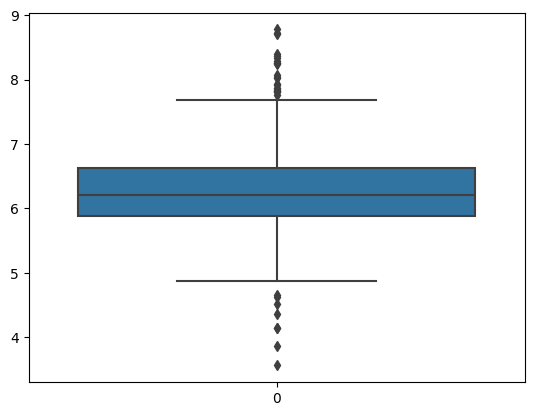

In [3]:
# The outliers are the asterisks sitting outside the whiskers, which delimit the interquartile range proximity rule boundaries:
sns.boxplot(boston['RM'])
plt.show()

In [4]:
def find_boundaries(df, variable, distance, rule="inter-quartile"):
    if rule == "inter-quartile":
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
        return upper_boundary, lower_boundary
    elif rule == "meanstddev":
        lower_boundary = df[variable].mean() - (df[variable].std() * distance)
        upper_boundary = df[variable].mean() + (df[variable].std() * distance)
        return upper_boundary, lower_boundary

In [5]:
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 1.5)

In [6]:
# Let's print those limits beyond which we will consider a value an outlier:
RM_upper_limit, RM_lower_limit

(7.730500000000001, 4.778499999999999)

In [7]:
outliers_RM = np.where(boston['RM'] > RM_upper_limit, True, np.where(boston['RM'] < RM_lower_limit, True, False))
boston_trimmed = boston.loc[~(outliers_RM)]

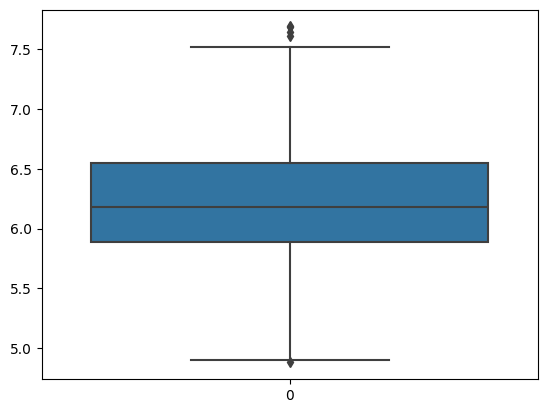

In [8]:
sns.boxplot(boston_trimmed['RM'])
plt.show()

In [9]:
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 3, rule="meanstddev")
RM_upper_limit, RM_lower_limit

(8.392485817597748, 4.176782957105809)

In [10]:
outliers_RM = np.where(boston['RM'] > RM_upper_limit, True, np.where(boston['RM'] < RM_lower_limit, True, False))
boston_trimmed = boston.loc[~(outliers_RM)]

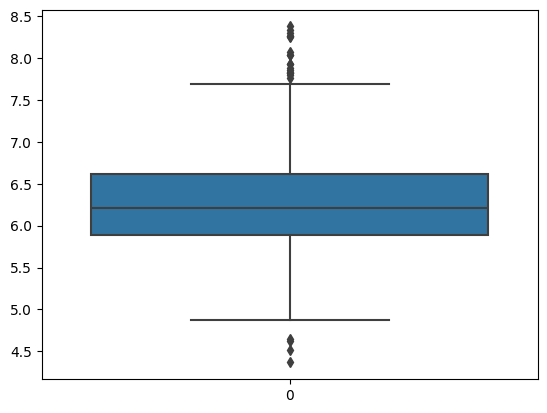

In [11]:
sns.boxplot(boston_trimmed['RM'])
plt.show()

## Performing winsorization

**Winsorization, or winsorizing, is the process of transforming the data by limiting the
extreme values, that is, the outliers, to a certain arbitrary value, closer to the mean of the
distribution**. 

Winsorizing is different from trimming because the **extreme values are not
removed, but are instead replaced by other values.** A typical strategy involves setting
outliers to a specified percentile.

For example, with 90% winsorization, we set all data below the 5th percentile to the value at
the 5th percentile and all data above the 95th percentile to the value at the 95th percentile.

**Winsorization is symmetric**; therefore, the winsorized mean of a symmetric distribution
provides an unbiased representation of the distribution of the variable.

In [12]:
boston = pd.read_csv("data/boston.csv")
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
import scipy.stats as stats

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

c:\Users\Fakulteta\Desktop\WORK\python-machine-learning-public\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


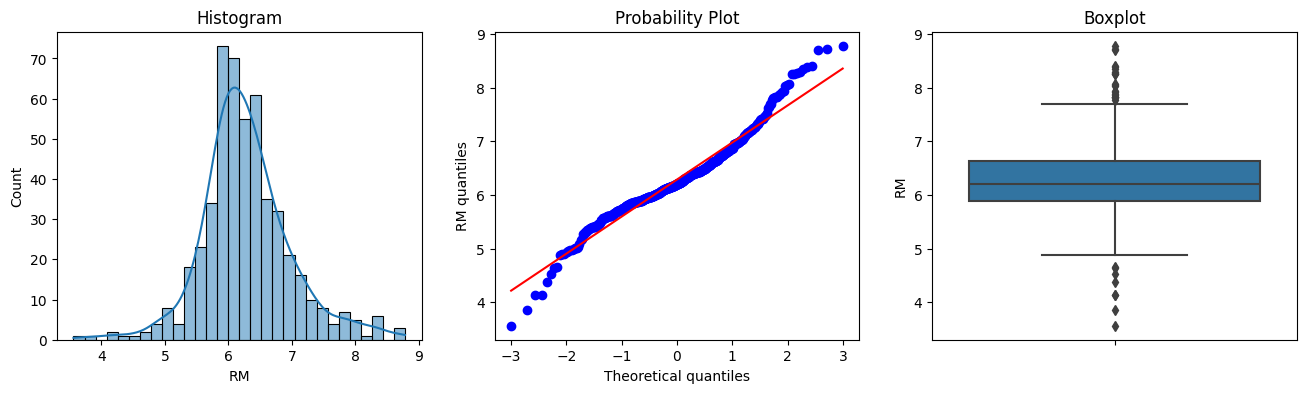

In [14]:
diagnostic_plots(boston, 'RM')

c:\Users\Fakulteta\Desktop\WORK\python-machine-learning-public\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


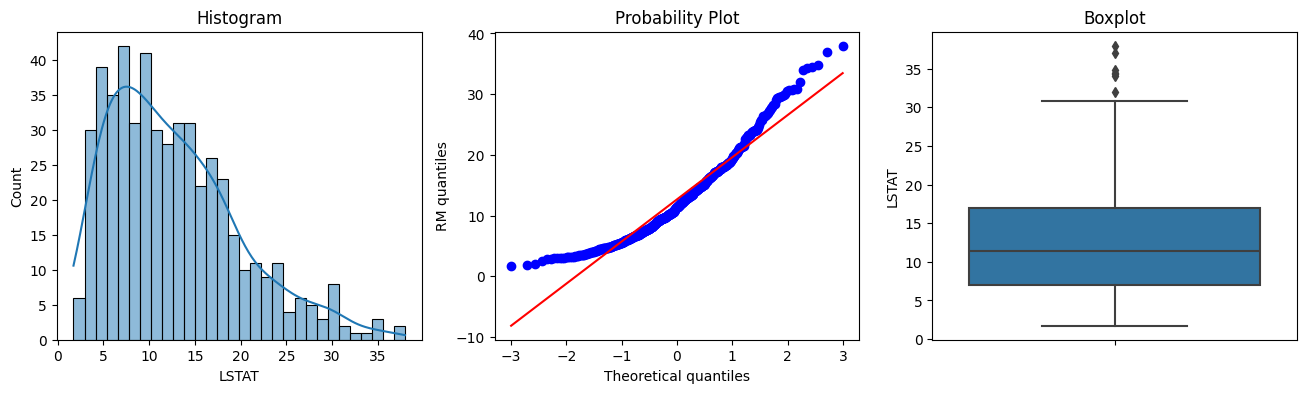

In [15]:
diagnostic_plots(boston, 'LSTAT')

c:\Users\Fakulteta\Desktop\WORK\python-machine-learning-public\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


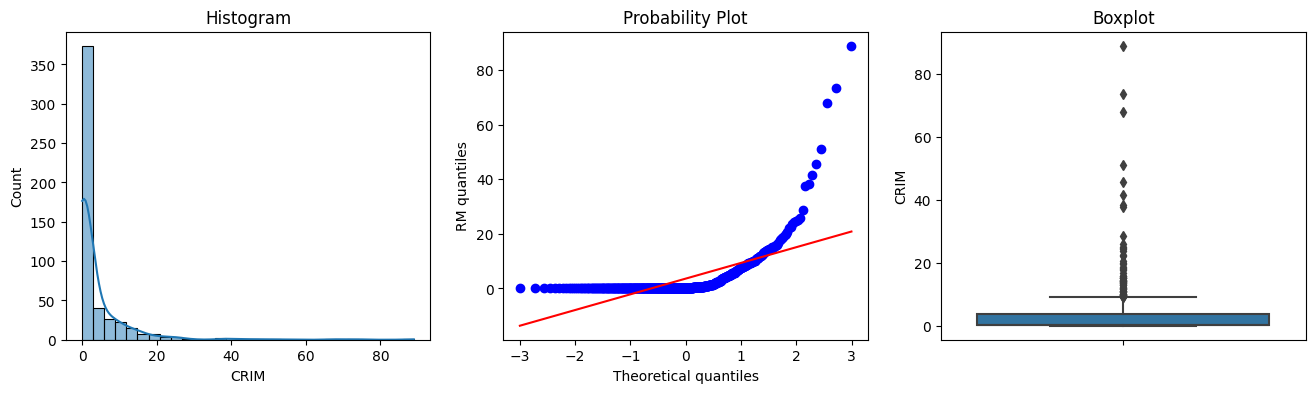

In [16]:
diagnostic_plots(boston, 'CRIM')

In [17]:
from feature_engine.outliers import Winsorizer

windsorizer = Winsorizer(capping_method='quantiles', 
                          tail='both', # cap left, right or both tails 
                          variables=['RM', 'LSTAT', 'CRIM'])

windsorizer.fit(boston)

Winsorizer(capping_method='quantiles', fold=0.05, tail='both',
           variables=['RM', 'LSTAT', 'CRIM'])

With Winsorizer from Feature-engine, we can replace the values by the
percentiles at the left and right tails or only at one of the tails by setting
the argument tail to either both, left, or right.

In [18]:
boston_t = windsorizer.transform(boston)

c:\Users\Fakulteta\Desktop\WORK\python-machine-learning-public\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


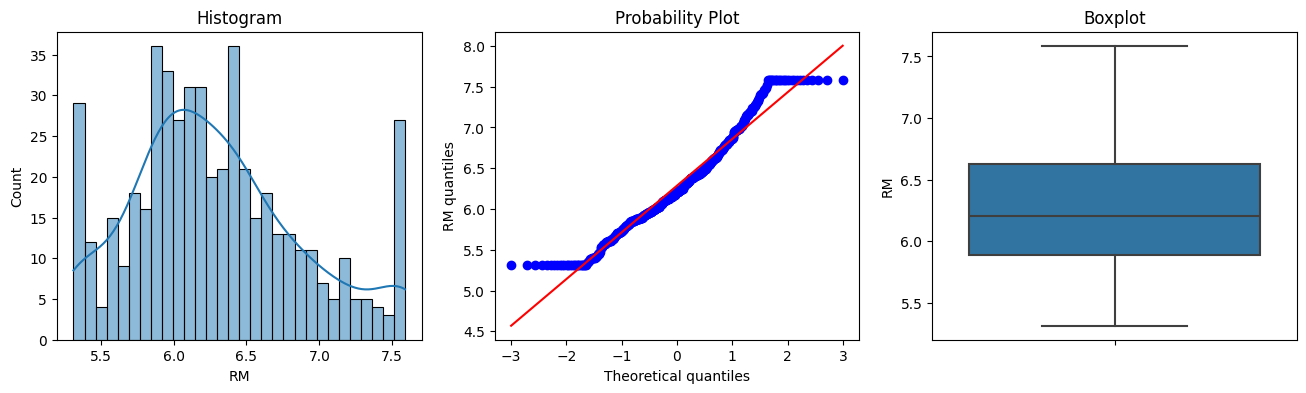

In [19]:
diagnostic_plots(boston_t, 'RM')

In [20]:
# we can inspect the minimum caps for each variable
windsorizer.left_tail_caps_

{'RM': 5.314, 'LSTAT': 3.7075, 'CRIM': 0.027909999999999997}

In [21]:
# we can inspect the maximum caps for each variable
windsorizer.right_tail_caps_

{'RM': 7.5875, 'LSTAT': 26.8075, 'CRIM': 15.78915}

c:\Users\Fakulteta\Desktop\WORK\python-machine-learning-public\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


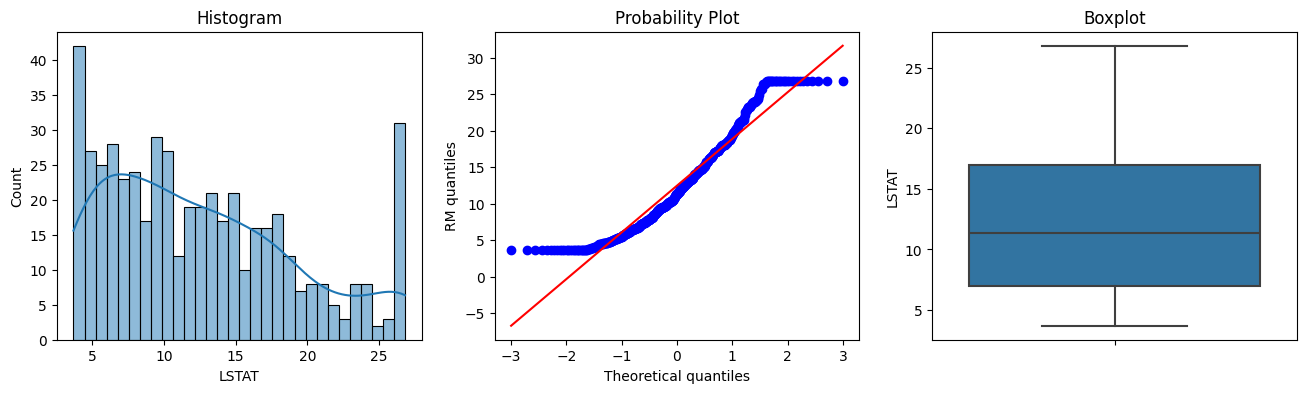

In [22]:
diagnostic_plots(boston_t, 'LSTAT')

c:\Users\Fakulteta\Desktop\WORK\python-machine-learning-public\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


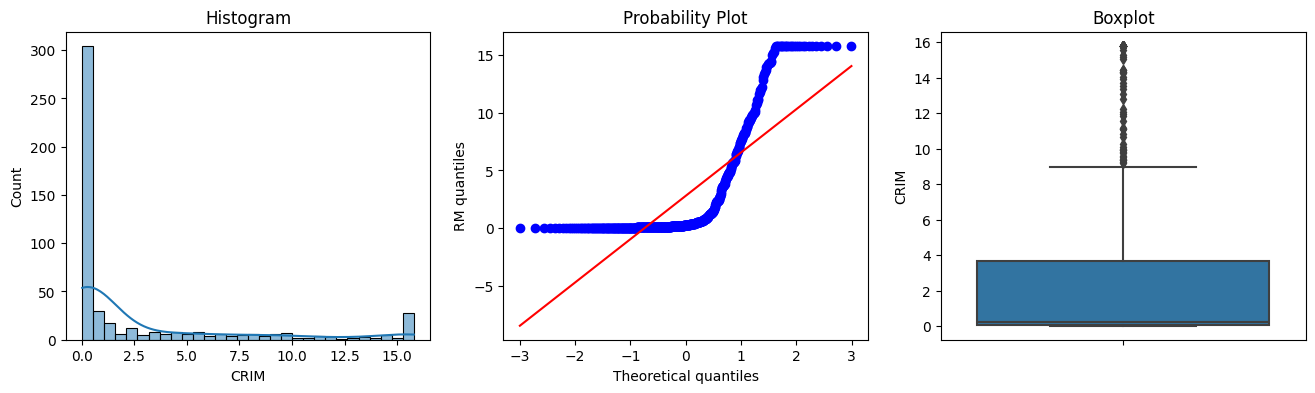

In [23]:
diagnostic_plots(boston_t, 'CRIM')

## Capping the variable at arbitrary maximum and minimum values

**Similarly to winsorization, we can replace the extreme values by values closer to other
values in the variable**, by determining the maximum and minimum boundaries with the
mean plus or minus the standard deviation, or the inter-quartile range proximity rule. 

This
procedure is also called bottom and top coding, censoring, or capping. We can cap both
extremes of the distribution or just one of the tails, depending on where we find the outliers
in the variable.

In [24]:
boston = pd.read_csv("data/boston.csv")
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


We can cap many variables at a time, utilizing the open source package, Feature-engine.

In [25]:
from feature_engine.outliers import Winsorizer

windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsorizer.fit(boston)

Winsorizer(tail='both', variables=['RM', 'LSTAT', 'CRIM'])

In [26]:
boston_t = windsorizer.transform(boston)

In [27]:
# we can inspect the minimum caps for each variable
windsorizer.left_tail_caps_

{'RM': 4.178866844348072,
 'LSTAT': -8.748941668844733,
 'CRIM': -22.16560049657506}

In [28]:
# we can inspect the maximum caps for each variable
windsorizer.right_tail_caps_

{'RM': 8.390401930355486,
 'LSTAT': 34.05506815105818,
 'CRIM': 29.392647611199564}